# Exploratory Analysis
This notebook just contains misc data exploring.
Run the snakemake workflow prior to this notebook.

In [272]:
DATA_DIR = "/home/jack/unm_gra/data/LAA/Homosapiens-SINGLEPROTEIN-1100"

## Setup

In [273]:
import polars as pl
import os
import seaborn as sns
import matplotlib.pyplot as plt

## Plot Promiscuity Degree (PD) Data
Promiscuity Degree = Number of unique targets a given ligand (i.e., compound) was active against. This is the same definition used in https://pubs.acs.org/doi/10.1021/acsomega.8b02998

In [274]:
activity_df = pl.read_csv(os.path.join(DATA_DIR, "activities", "activity_info.tsv"), separator="\t")
assay_df = pl.read_csv(os.path.join(DATA_DIR, "assays", "assay_info.tsv"), separator="\t")

In [275]:
joined = activity_df.join(assay_df, on="assay_id", how="inner")
mol2tid_df = joined.select(["molregno", "tid"]).unique()
pd_df = (
    mol2tid_df
    .group_by("molregno")
    .agg(pl.count("tid").alias("promiscuity_degree"))
)

<Axes: xlabel='promiscuity_degree', ylabel='Count'>

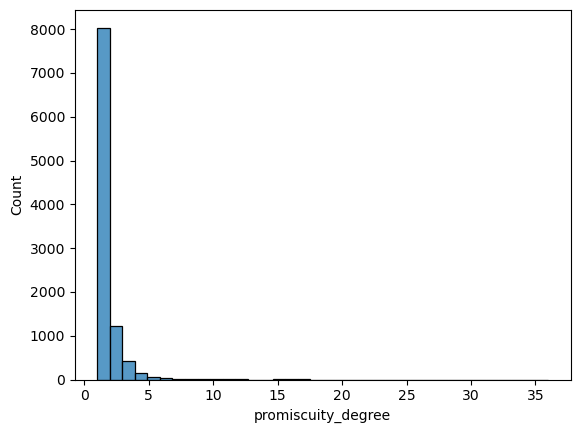

In [276]:
sns.histplot(pd_df, x="promiscuity_degree", bins=max(pd_df["promiscuity_degree"]))

In [277]:
breaks = [1, 4]
labels = ["1", "2-4", "≥5"]
pd_df = pd_df.with_columns(pl.col("promiscuity_degree").cut(breaks=breaks, labels=labels).alias("PD_bin"))
bin_counts = pd_df["PD_bin"].value_counts(sort=False)
bin_counts

PD_bin,count
cat,u32
"""1""",8036
"""2-4""",1803
"""≥5""",156


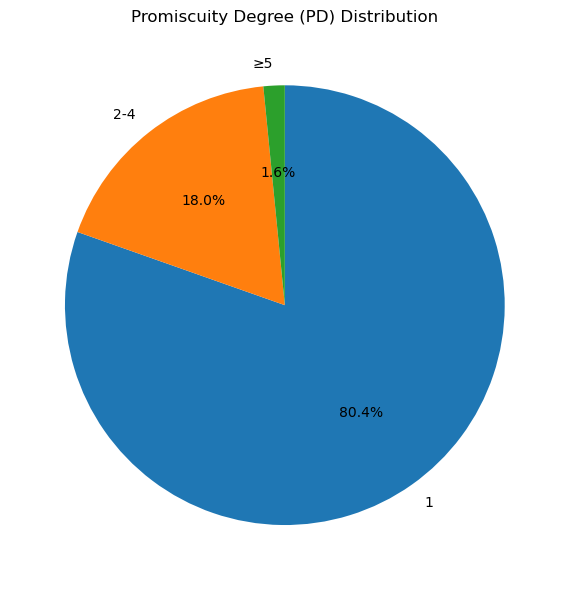

In [278]:
pie_labels, pie_counts = bin_counts["PD_bin"], bin_counts["count"]
plt.figure(figsize=(6, 6))
plt.pie(
    pie_counts,
    labels=pie_labels,
    autopct='%1.1f%%',
    startangle=90, 
    counterclock=False
)
plt.title("Promiscuity Degree (PD) Distribution")
plt.tight_layout()
plt.show()

## KinMap Visualizations
Gathering info on number of assays, number of unique active compounds for KinMap
visuals.
http://www.kinhub.org/kinmap/

*Note*: To download KinMap images you have to select "SVG" and then edit the data using the fix here: https://askubuntu.com/a/1265209 

In [279]:
def prepare_kinmap_df_with_bins(
    df: pl.DataFrame,
    colname: str,
    cutoffs: list[int],
    colors: list[str],
    min_size: int = None, 
    max_size: int = None  # Optional cap on 'size'
) -> pl.DataFrame:
    """
    Prepares a KinMap visualization DataFrame.

    Parameters:
        df: Input DataFrame with at least 'xName' and the specified `colname`.
        colname: Name of the numeric column to use for binning and size.
        cutoffs: List of upper bounds for the bins (must be increasing).
        colors: List of colors, must be len(cutoffs) + 1.
        min_size: Optional minimum value on the 'size' column (e.g., 100 for visualization).
        max_size: Optional cap on the 'size' column (e.g., 100 for visualization).

    Returns:
        A DataFrame with columns: xName, size, fill.
    """
    if len(colors) != len(cutoffs) + 1:
        raise ValueError("Number of colors must be one more than number of cutoffs.")

    col = pl.col(colname)

    # Construct fill color expression based on cutoffs
    expr = pl.when(col < cutoffs[0]).then(pl.lit(colors[0]))
    for i in range(1, len(cutoffs)):
        expr = expr.when(col < cutoffs[i]).then(pl.lit(colors[i]))
    expr = expr.otherwise(pl.lit(colors[-1]))

    # Optional size cap
    max_size = df[col].max() if max_size is None else max_size
    min_size = df[col].min() if min_size is None else min_size
    size_expr = pl.when(col < max_size).then(col).otherwise(max_size)
    size_expr = pl.when(col < min_size).then(pl.when(col == 0).then(0).otherwise(min_size)).otherwise(size_expr)

    return df.select([
        pl.col("xName"),
        size_expr.alias("size"),
        expr.alias("fill")
    ])

In [280]:
kinmap_df = pl.read_csv("../data/kinmap_file.tsv", separator="\t", columns=["xName", "UniprotID"])
kinmap_df = kinmap_df.unique(subset=["UniprotID"])

In [281]:
assert not(kinmap_df["xName"].is_duplicated().any())

In [282]:
chembl_target_df = pl.read_csv("/home/jack/unm_gra/data/LAA/Homosapiens-SINGLEPROTEIN-1100/targets/target_info.tsv", separator="\t", columns=["accession", "tid"])
chembl_target_df = chembl_target_df.rename({"accession": "UniprotID"})
chembl_target_df = chembl_target_df.unique(subset=["UniprotID"]) # currently there are duplicates bc some targets are assigned to multiple different families

In [283]:
ktarget_df = kinmap_df.join(chembl_target_df, on="UniprotID", how="inner")

In [284]:
ktarget_df.head()

xName,UniprotID,tid
str,str,i64
"""YANK1""","""Q8WU08""",102774
"""ZAP70""","""P43403""",12214
"""PLK3""","""Q9H4B4""",100412
"""CaMK2b""","""Q13554""",10396
"""smMLCK""","""Q15746""",10250


In [285]:
tid2assaycount_df = (
    assay_df
    .group_by("tid")
    .agg(pl.count("assay_id").alias("n_assays"))
)

In [286]:
tid2ligandcount_df = (
    mol2tid_df
    .group_by("tid")
    .agg(pl.count("molregno").alias("n_ligands"))
)

In [287]:
ktarget_df = ktarget_df.join(tid2assaycount_df, on="tid", how="left")
ktarget_df = ktarget_df.with_columns(ktarget_df["n_assays"].fill_null(0))

In [288]:
ktarget_df = ktarget_df.join(tid2ligandcount_df, on="tid", how="left")
ktarget_df = ktarget_df.with_columns(ktarget_df["n_ligands"].fill_null(0))

In [289]:
ktarget_df

xName,UniprotID,tid,n_assays,n_ligands
str,str,i64,u32,u32
"""YANK1""","""Q8WU08""",102774,30,0
"""ZAP70""","""P43403""",12214,212,8
"""PLK3""","""Q9H4B4""",100412,163,1
"""CaMK2b""","""Q13554""",10396,126,0
"""smMLCK""","""Q15746""",10250,119,2
…,…,…,…,…
"""CDKL3""","""Q8IVW4""",103446,32,1
"""EphA8""","""P29322""",30010,100,0
"""YES""","""P07947""",18033,245,23


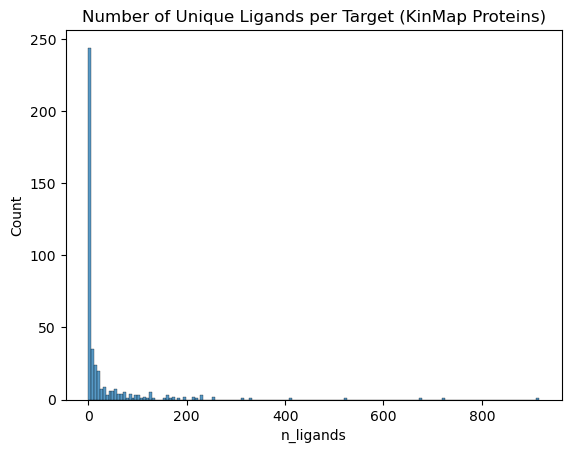

In [291]:
sns.histplot(ktarget_df, x="n_ligands")
plt.title("Number of Unique Ligands per Target (KinMap Proteins)")
plt.show()

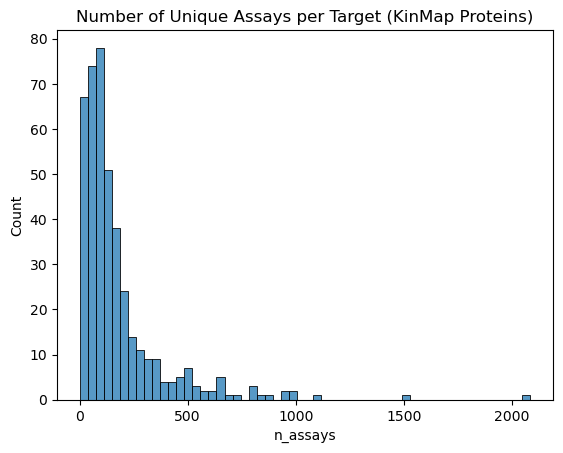

In [292]:
sns.histplot(ktarget_df, x="n_assays")
plt.title("Number of Unique Assays per Target (KinMap Proteins)")
plt.show()

In [293]:
def create_kinmap_csv(df: pl.DataFrame, col: str, size_cutoffs: list, colors: list, save_pth: str):
    # just fixing size for easier vis
    kinmap_csv_df = prepare_kinmap_df_with_bins(df, col, size_cutoffs, colors, max_size=15, min_size=15)
    kinmap_csv_df.write_csv(save_pth)

In [297]:
# save n_assay data
size_cutoffs = [5, 50, 100]
colors = sns.color_palette("viridis", len(size_cutoffs) + 1).as_hex() # maps sizes to color
print(colors)
pth = "/home/jack/unm_gra/data/LAA/Homosapiens-SINGLEPROTEIN-1100/addl_files/kinmap_nassay_vis.csv"
create_kinmap_csv(ktarget_df, "n_assays", size_cutoffs, colors, pth)

['#414487', '#2a788e', '#22a884', '#7ad151']


In [295]:
# save n_ligand data
size_cutoffs = [5, 50, 100] # 1-4, 5-49, 50-99, 100+
colors = sns.color_palette("viridis", len(size_cutoffs) + 1).as_hex() # maps sizes to color
pth = "/home/jack/unm_gra/data/LAA/Homosapiens-SINGLEPROTEIN-1100/addl_files/kinmap_nligand_vis.csv"
create_kinmap_csv(ktarget_df, "n_ligands", size_cutoffs, colors, pth)

In [296]:
# save main df
ktarget_df.write_csv("/home/jack/unm_gra/data/LAA/Homosapiens-SINGLEPROTEIN-1100/addl_files/kinmap_data.csv")